In [1]:
from google.cloud import bigquery
import warnings
warnings.filterwarnings('ignore')

# Initialize BigQuery Client
client = bigquery.Client.from_service_account_json("secrets/serviceKey.json")

project_id = "idmpproject-441123"
dataset_id = "uberFareEstimation"
uber_table_id = 'uber_data'
weather_table_id = 'weather_data'

In [4]:
table_path = f"{project_id}.{dataset_id}.{uber_table_id}"

# Define the query
query = f"""
    SELECT *
    FROM `{table_path}`
"""

# Run the query
query_job = client.query(query)

# Wait for the query to complete and fetch results
results = query_job.result()

uber_df = results.to_dataframe()



table_path = f"{project_id}.{dataset_id}.{weather_table_id}"

# Define the query
query = f"""
    SELECT *
    FROM `{table_path}`
"""

# Run the query
query_job = client.query(query)

# Wait for the query to complete and fetch results
results = query_job.result()

weather_df = results.to_dataframe()

In [6]:
print(uber_df.shape)
print(weather_df.shape)

(330568, 9)
(4147, 8)


In [ ]:
uber_df

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,name
0,0.94,Uber,2018-11-28 23:30:00,North End,North Station,4.5,1.0,39765,UberPool
1,0.94,Uber,2018-12-14 19:30:00,North End,North Station,4.5,1.0,437984,UberPool
2,0.63,Uber,2018-11-27 21:30:00,Financial District,South Station,4.5,1.0,1644,UberPool
3,0.63,Uber,2018-12-15 15:00:00,Financial District,South Station,4.5,1.0,10780,UberPool
4,0.63,Uber,2018-12-15 13:30:00,Financial District,South Station,4.5,1.0,21598,UberPool
...,...,...,...,...,...,...,...,...,...
330563,7.46,Uber,2018-12-02 12:30:00,Northeastern University,Financial District,59.5,1.0,584592,Black SUV
330564,3.45,Uber,2018-11-28 14:00:00,South Station,Back Bay,61.5,1.0,372302,Black SUV
330565,0.62,Uber,2018-12-17 17:00:00,West End,Haymarket Square,61.5,1.0,260720,Black SUV
330566,3.61,Uber,2018-11-29 20:00:00,Back Bay,North End,67.0,1.0,520519,Black SUV


In [8]:
weather_df

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,36.26,West End,0.00,1012.37,0.0,2018-11-29 18:30:00,0.69,6.84
1,29.95,Beacon Hill,0.00,1015.19,0.0,2018-12-14 18:30:00,0.85,2.43
2,29.85,Boston University,0.00,1015.20,0.0,2018-11-27 11:30:00,0.85,2.33
3,29.83,Fenway,0.00,1015.20,0.0,2018-12-16 04:30:00,0.85,2.35
4,29.99,Haymarket Square,0.00,1015.19,0.0,2018-12-17 06:30:00,0.85,2.46
...,...,...,...,...,...,...,...,...
4142,44.50,Financial District,0.78,1000.87,0.0,2018-11-26 07:00:00,0.96,3.58
4143,44.48,North End,0.78,1000.87,0.0,2018-11-27 22:00:00,0.96,3.55
4144,44.38,North Station,0.78,1000.87,0.0,2018-11-30 12:30:00,0.96,3.51
4145,30.25,Beacon Hill,0.78,1035.03,0.0,2018-12-01 07:30:00,0.68,2.32


In [10]:
uber_df.rename(columns={"time_stamp": "uber_time_stamp"}, inplace=True)
weather_df.rename(columns={"time_stamp": "weather_time_stamp"}, inplace=True)

In [64]:
import pandas as pd

# Perform the join
joined_df = pd.merge(
    uber_df,
    weather_df,
    left_on=["uber_time_stamp", "source"],
    right_on=["weather_time_stamp", "location"],
    how="left"  
)

# Replace missing values in 'location' with the values from 'source'
joined_df['location'] = joined_df['location'].fillna(joined_df['source'])

# Ensure the DataFrame is sorted by location and timestamp
joined_df = joined_df.sort_values(by=['location', 'uber_time_stamp'])

# Display the result
joined_df.head(5)


,distance,cab_type,uber_time_stamp,destination,source,price,surge_multiplier,id,name,temp,location,clouds,pressure,rain,weather_time_stamp,humidity,wind
254787,6.26,Uber,2018-11-26 03:30:00,South Station,Back Bay,34.0,1.0,279026,Black,NaN,Back Bay,NaN,NaN,NaN,NaT,NaN,NaN
330,1.40,Uber,2018-11-26 04:30:00,Boston University,Back Bay,4.5,1.0,203607,UberPool,NaN,Back Bay,NaN,NaN,NaN,NaT,NaN,NaN
30645,1.08,Uber,2018-11-26 04:30:00,Northeastern University,Back Bay,7.5,1.0,150814,WAV,NaN,Back Bay,NaN,NaN,NaN,NaT,NaN,NaN
37300,1.10,Uber,2018-11-26 04:30:00,Northeastern University,Back Bay,7.5,1.0,637167,UberX,NaN,Back Bay,NaN,NaN,NaN,NaT,NaN,NaN
58139,1.44,Uber,2018-11-26 04:30:00,Boston University,Back Bay,8.5,1.0,27464,WAV,NaN,Back Bay,NaN,NaN,NaN,NaT,NaN,NaN


In [65]:
# Ensure the DataFrame is sorted by location and timestamp
joined_df = joined_df.sort_values(by=['location', 'uber_time_stamp'])

# List of weather columns to fill
weather_columns = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']

# Create a helper column to track the source timestamp for weather data
joined_df['weather_source_timestamp'] = joined_df['uber_time_stamp']

# Function to fill weather columns and propagate the source timestamp
def fill_weather_and_timestamp(group):
    # Fill weather columns using nearest interpolation
    for col in weather_columns:
        group[col] = group[col].interpolate(method='nearest', limit_direction='both')
    
    # Propagate the source timestamp for missing weather values
    group['weather_source_timestamp'] = group['weather_source_timestamp'].where(
        group[weather_columns].notna().all(axis=1)  # Ensure all weather columns are non-NaN
    ).ffill().bfill()  # Fill forward and backward for timestamps
    
    return group

# Apply the function group-wise
joined_df = joined_df.groupby('location').apply(fill_weather_and_timestamp)

# Check the result
joined_df.head(5)

distance cab_type     uber_time_stamp  \
location                                                 
Back Bay 254787      6.26     Uber 2018-11-26 03:30:00   
         330         1.40     Uber 2018-11-26 04:30:00   
         30645       1.08     Uber 2018-11-26 04:30:00   
         37300       1.10     Uber 2018-11-26 04:30:00   
         58139       1.44     Uber 2018-11-26 04:30:00   

                             destination    source  price  surge_multiplier  \
location                                                                      
Back Bay 254787            South Station  Back Bay   34.0               1.0   
         330           Boston University  Back Bay    4.5               1.0   
         30645   Northeastern University  Back Bay    7.5               1.0   
         37300   Northeastern University  Back Bay    7.5               1.0   
         58139         Boston University  Back Bay    8.5               1.0   

                     id      name   temp  location  clouds  pressure    rain  \
location                                                                       
Back Bay 254787  279026     Black  40.39  Back Bay    0.92   1013.79  0.0000   
         330     203607  UberPool    NaN  Back Bay     NaN       NaN     NaN   
         30645   150814       WAV  38.02  Back Bay    1.00   1020.06  0.0182   
         37300   637167     UberX  36.42  Back Bay    0.90   1018.82  0.0000   
         58139    27464       WAV  41.18  Back Bay    0.89   1026.16  0.0000   

                weather_time_stamp  humidity  wind weather_source_timestamp  
location                                                                     
Back Bay 254787                NaT      0.93  2.71      2018-11-26 03:30:00  
         330                   NaT       NaN   NaN      2018-11-26 03:30:00  
         30645                 NaT      0.86  1.87      2018-11-26 04:30:00  
         37300                 NaT      0.70  3.73      2018-11-26 04:30:00  
         58139                 NaT      0.85  5.17      2018-11-26 04:30:00

In [66]:
# Step 1: Replace 'weather_time_stamp' with 'weather_source_timestamp' where available
joined_df['weather_time_stamp'] = joined_df['weather_source_timestamp'].combine_first(joined_df['weather_time_stamp'])

# Step 2: Remove 'weather_source_timestamp' column
joined_df = joined_df.drop(columns=['weather_source_timestamp'])

# Step 3: Count rows with any null value
rows_before = len(joined_df)
joined_df = joined_df.dropna()  # Remove rows with any null values
rows_after = len(joined_df)

# Step 4: Print the number of rows removed
rows_removed = rows_before - rows_after
print(f"Number of rows removed: {rows_removed}")

Number of rows removed: 17


In [74]:
from sklearn.preprocessing import StandardScaler

# Select the weather-related columns and price
weather_columns = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'price']
selected_df = joined_df[weather_columns]

# Separate the weather columns and price
weather_data = selected_df.drop(columns=['price'])
price_data = selected_df['price']

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the weather data
scaled_data = scaler.fit_transform(weather_data)

# Create a DataFrame with the scaled values
scaled_df = pd.DataFrame(scaled_data, columns=weather_data.columns, index=selected_df.index)

# Add the 'price' column back (ensure index is aligned)
scaled_df['price'] = price_data

# Calculate the correlation
correlation_with_price_scaled = scaled_df.corr()['price'].sort_values(ascending=False)

# Print the correlations
print("Correlation with price (scaled weather columns):")
print(correlation_with_price_scaled)


Correlation with price (scaled weather columns):
price       1.000000
temp        0.004259
clouds      0.003939
humidity    0.003918
pressure    0.001107
rain       -0.005391
wind       -0.006198
Name: price, dtype: float64


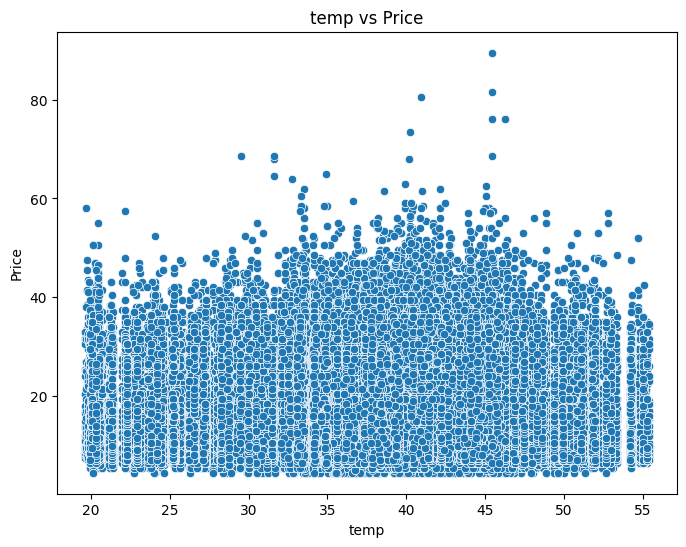

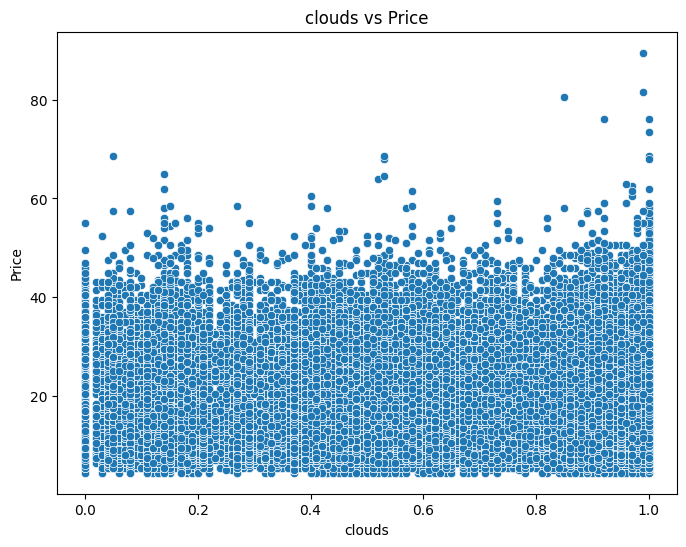

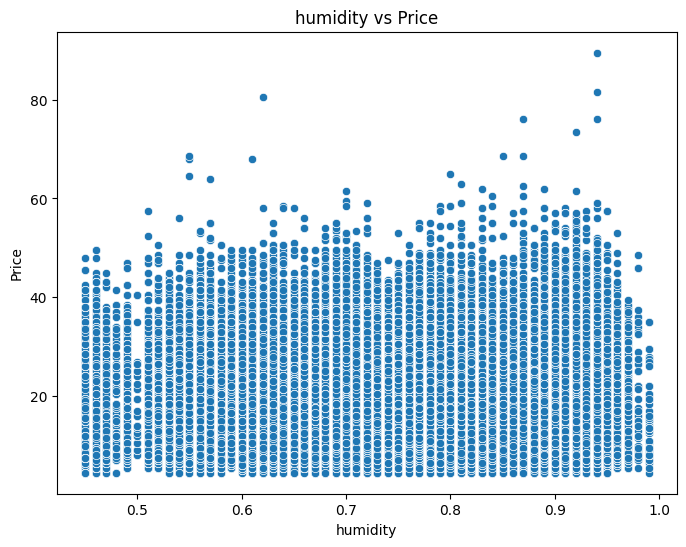

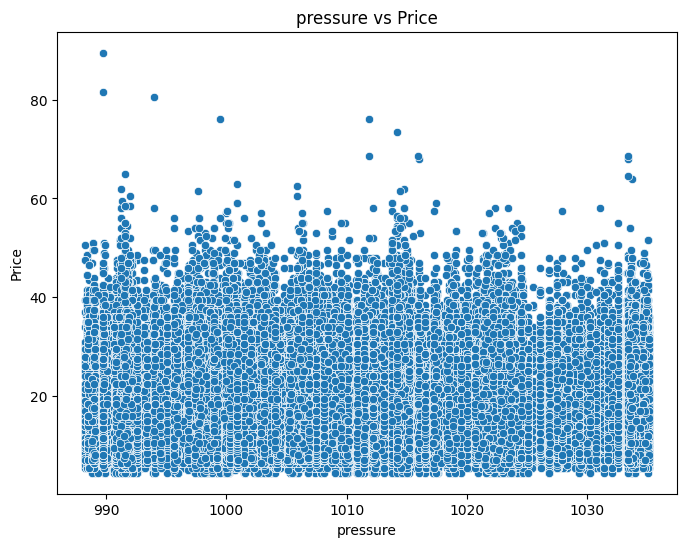

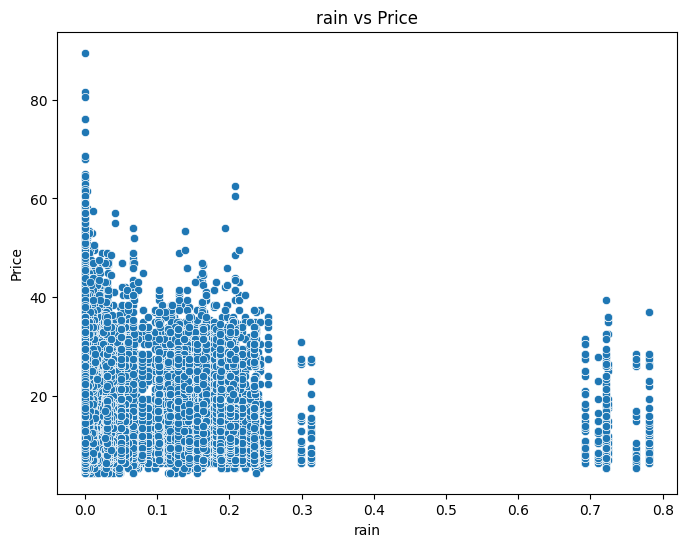

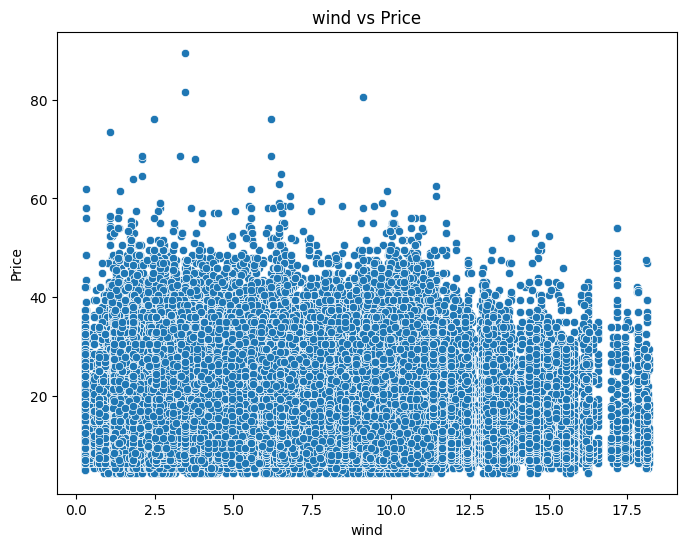

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot scatter plots for weather features against price
weather_columns = ['temp', 'clouds', 'humidity', 'pressure', 'rain', 'wind']

for col in weather_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=joined_df[col], y=joined_df['price'])
    plt.title(f'{col} vs Price')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

In [ ]:
# importing libraries for machine learning

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, r2_score


# change features depending on correlation metrics/what will make model most accurate
features = ['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'surge_multiplier']

# variable that is being predicted
target_variable = 'price'

# Extract X (features) and y (target) from the data
X = df[features]
y = df[target_variable]


In [ ]:
# preprocessing for model

# Convert 'time_stamp' into datetime format
X['time_stamp'] = pd.to_datetime(X['time_stamp'])

# Extract useful time-based features
X['hour'] = X['time_stamp'].dt.hour
X['day_of_week'] = X['time_stamp'].dt.dayofweek

# Drop the original 'time_stamp' column as it's no longer needed
X = X.drop('time_stamp', axis=1)

In [ ]:
# Configures a ColumnTransformer to preprocess categorical features using OneHotEncoder
# leaves numerical features unchanged for model training



# Define categorical and numerical features
categorical_features = ['cab_type', 'source', 'destination']
numerical_features = ['distance', 'surge_multiplier', 'hour', 'day_of_week']

# Set up the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

# Display the preprocessor to confirm setup
print(preprocessor)

In [ ]:
# splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# creating pipeline and training the model

# Set up the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create a pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_model)
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

print("Pipeline training complete.")

In [ ]:
# making predictions and evaluating model

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model using MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Evaluate the model using R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

In [ ]:
# getting importance of each feature in the model

# Access the trained Random Forest model from the pipeline
rf_model_trained = pipeline.named_steps['regressor']

# Get feature importances
feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_features = list(feature_names) + numerical_features
feature_importances = rf_model_trained.feature_importances_

# Combine feature names and their importances into a DataFrame
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)
